In [72]:
import numpy as np
from pyESN.pyESN import ESN
from matplotlib import pyplot as plt
from utils import *
from scipy.signal import periodogram,decimate

In [73]:
eeg = get_eeg_by_fileindex(1)
metadata = read_metadata_by_fileindex(1)
eeg = decimate(eeg, q=10).reshape(-1, 1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
eeg = scaler.fit_transform(eeg).squeeze()

In [74]:
rem_idx = metadata[metadata['label'] == .5].index
rem = np.array([0])
for idx in rem_idx:
    epoch_range_samples = (idx*10*50,(idx*10*50)+500)
    rem = np.hstack([rem,eeg[epoch_range_samples[0]:epoch_range_samples[1]]])
rem = np.delete(rem,0)

In [75]:
esn = ESN(n_inputs = 1,
          n_outputs = 1,
          n_reservoir = 500,
          spectral_radius = 1.5,
          random_state=42)

In [76]:
trainlen = 2000
future = 2000
pred_training = esn.fit(np.ones(trainlen),rem[:trainlen])

In [86]:
prediction = esn.predict(np.ones(100000))

ValueError: Must pass 2-d input. shape=(200, 201, 1)

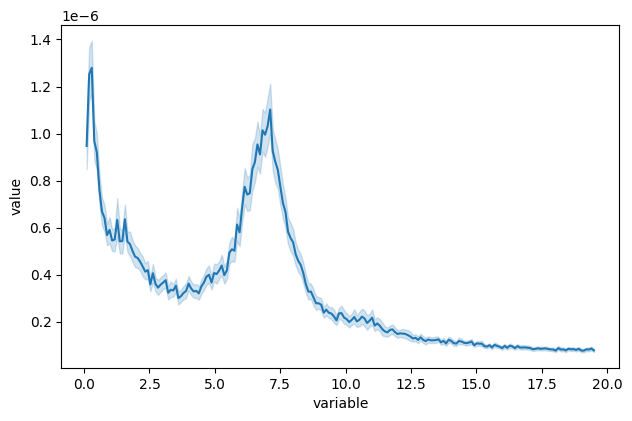

<Figure size 720x445 with 0 Axes>

In [87]:
spectra = []
for i in range(0,len(rem),500):
    f, Pxx = periodogram(rem[i:i+500], 50,scaling='spectrum')
    spectra.append(Pxx[:201])
import seaborn as sns
plt.figure(figsize=(7.2,4.45))
ax = sns.lineplot(data=pd.DataFrame(spectra,columns=np.linspace(0,19.5,201)).iloc[:,1:].melt(),x='variable',y='value')
spectra = []
for i in range(0,len(prediction),500):
    f, Pxx = periodogram(prediction[i:i+500], 50,scaling='spectrum')
    spectra.append(Pxx[:201])
import seaborn as sns
plt.figure(figsize=(7.2,4.45))
ax = sns.lineplot(data=pd.DataFrame(spectra,columns=np.linspace(0,19.5,201)).iloc[:,1:].melt(),x='variable',y='value')
# for j in range(0,90000,10000):
#     spectra = []
#     for i in range(j,j+10000,500):
#         f, Pxx = periodogram(prediction[i:i+500].squeeze(), 50,scaling='spectrum')
#         spectra.append(Pxx[:201])
#     ax = sns.lineplot(data=pd.DataFrame(spectra,columns=np.linspace(0,19.5,201)).iloc[:,1:].melt(),x='variable',y='value')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V**2)')

ax.set(yscale='log')
plt.savefig('orig_psd.pgf',bbox_inches='tight')

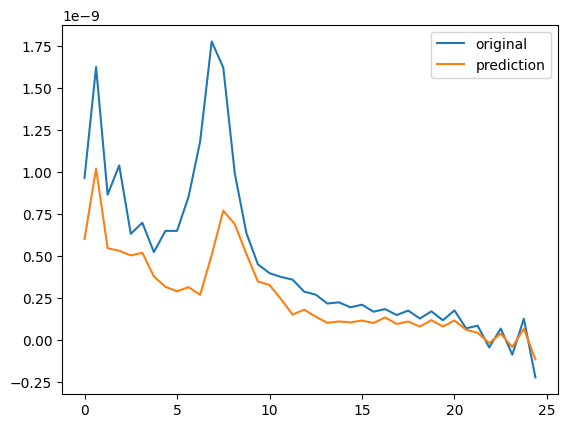

In [89]:
from scipy.signal import resample

f, Pxx = periodogram(rem, 50,scaling='spectrum')
Pxx,f = resample(x=Pxx,num=40,t=f)
plt.plot(f,Pxx,label='original')
# for i in range(0,100000,10000): 
#     f, Pxx = periodogram(prediction[i:i+10000].squeeze(), 50,scaling='spectrum')
#     Pxx,f = resample(x=Pxx,num=40,t=f)
#     plt.plot(x, Pxx,label=f'{i}')
f, Pxx = periodogram(prediction.squeeze(), 50,scaling='spectrum')
Pxx,f = resample(x=Pxx,num=40,t=f)
plt.plot(f, Pxx,label=f'prediction')
plt.legend()
plt.savefig('final.pgf',bbox_inches='tight')

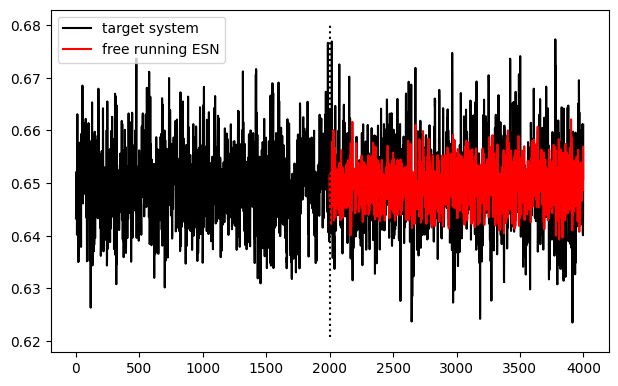

In [81]:
plt.figure(figsize=(7.2,4.45))
plt.plot(range(0,trainlen+future),rem[0:trainlen+future],'k',label="target system")
plt.plot(range(trainlen,trainlen+future),prediction,'r', label="free running ESN")
lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:')
plt.legend()
plt.savefig('rem.pgf',bbox_inches='tight')
